# **In this Project, we are challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
from pandas.io.json import json_normalize
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [ ]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

**This function creates connection to a database file**

In [ ]:
if os.path.isfile('/content/drive/My Drive/train_data/train_1.db'):
    conn_r = create_connection('/content/drive/My Drive/train_data/train_1.db')
    if conn_r is not None:
        
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From train_data;", conn_r)
        conn_r.commit()
        conn_r.close()

In [ ]:
data['date']=data['date'].apply(lambda x: str(x))
data['date'] =pd.to_datetime(data.date)
data=data.sort_values(by=['date'])
data.index=np.arange(data.shape[0])
# type(data.date.iloc[0])

data.shape

(342000, 13)

 **Sampled Training Dataset consist of 342000 rows and 13 columns**


In [ ]:
data.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'North America'}]",2016-08-01,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",2820652514257258467,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '5', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""7"", ""pageviews"": ""6"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1470055343,1,1470055343
1,Referral,"[{'index': '4', 'value': 'North America'}]",2016-08-01,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",2371112886977263623,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""30"", ""pageviews"": ""22...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1470097739,3,1470097739
2,Referral,"[{'index': '4', 'value': 'North America'}]",2016-08-01,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6997692197808690953,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '7', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""50"", ""pageviews"": ""30...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1470060696,1,1470060696
3,Social,[],2016-08-01,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0351632287593731316,"{""continent"": ""Europe"", ""subContinent"": ""South...","[{'hitNumber': '1', 'time': '0', 'hour': '1', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""referralPath"": ""/yt/about/"", ""campaign"": ""(n...",1470041295,1,1470041295
4,Referral,"[{'index': '4', 'value': 'North America'}]",2016-08-01,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3126493267998651969,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '16',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""41"", ""pageviews"": ""27...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1470094104,3,1470094104


The data fields in the given files are





* **fullVisitorId**- A unique identifier for each user of the Google Merchandise Store.
* **channelGrouping** - The channel via which the user came to the Store.
* **date** - The date on which the user visited the Store.
* **device** - The specifications for the device used to access the Store.
* **geoNetwork** - This section contains information about the geography of the user.
* **sessionId** - A unique identifier for this visit to the store.
* **socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* **totals** - This section contains aggregate values across the session.
* **trafficSource** - This section contains information about the Traffic Source from which the session originated.
* **visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
* **visitNumber** - The session number for this user. If this is the first session, then this is set to 1.
* **visitStartTime** - The timestamp (expressed as POSIX time)

 **[Device,  geoNetwork,  totals,  trafficSource]** 

 These Columns in the dataset are in **JSON** format. We need to convert it.

In [ ]:
def load_json_df(csv_path='data.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [ ]:
data.to_csv('trimmed_data.csv',index=False)

In [ ]:
train_no_json=load_json_df(csv_path='trimmed_data.csv')

Loaded trimmed_data.csv. Shape: (342000, 59)


In [ ]:
train_no_json.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.timeOnSite,totals.newVisits,totals.bounces,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,totals.sessionQualityDim,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,"[{'index': '4', 'value': 'North America'}]",2016-08-01,2820652514257258467,"[{'hitNumber': '1', 'time': '0', 'hour': '5', ...",Not Socially Engaged,1470055343,1,1470055343,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,7,6,1704,1,NaN,NaN,NaN,NaN,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",2016-08-01,2371112886977263623,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1470097739,3,1470097739,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Palo Alto,not available in demo dataset,universityfightnight.com,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,30,22,444,NaN,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),NaN,not available in demo dataset,/,True,NaN,NaN,NaN,NaN,NaN,NaN
2,Referral,"[{'index': '4', 'value': 'North America'}]",2016-08-01,6997692197808690953,"[{'hitNumber': '1', 'time': '0', 'hour': '7', ...",Not Socially Engaged,1470060696,1,1470060696,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,

In [ ]:
train_no_json.isnull().sum()

**There are lots of Missing value in the dataset, which needs to be handled.**

In [ ]:
const_cols = [c for c in train_no_json.columns if train_no_json[c].nunique(dropna=True)==1 ]
const_cols

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.newVisits',
 'totals.bounces',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd']

These columns contains only **single values** or **Null values**. It's better to **remove** them from the dataset 

In [ ]:
def convert_date(date):
    dic={'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun','07':'July','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}
    return dic[date[5:7]]


In [ ]:
train_no_json['Month']=train_no_json['date'].apply(convert_date)

In [ ]:
train_no_json['Month'].value_counts()

Nov     41082
Oct     39806
Dec     35183
Mar     32712
Aug     31942
Sep     31816
Apr     30162
Jan     29761
Feb     29170
July    14493
May     12992
Jun     12881
Name: Month, dtype: int64

In [ ]:
import plotly.express as px

In [ ]:
month_wise=train_no_json.groupby('Month')['totals.transactionRevenue'].agg(['size', 'count'])

# month_wise['month']=month_wise.index
# month_wise.index=np.arange(1,13,1)
month_wise

,size,count
Month,,
Apr,30162,301
Aug,31942,472
Dec,35183,453
Feb,29170,241
Jan,29761,284
July,14493,224
Jun,12881,202
Mar,32712,384
May,12992,231


In [ ]:
import plotly.graph_objects as go
import plotly.tools
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [ ]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [ ]:
cnt_srs = month_wise
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"], 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'rgba(50, 171, 96, 0.6)')

fig = make_subplots(rows=1, cols=2, 
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue Count"])


fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(height=600, width=1000, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
iplot(fig, filename='date-plots')

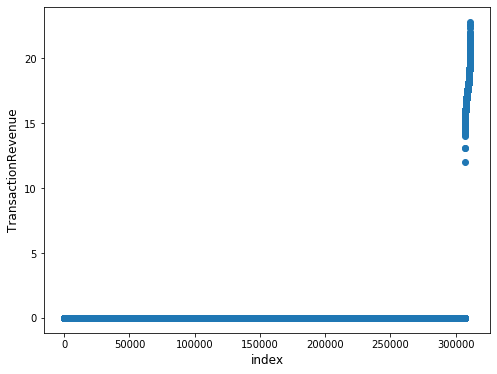

In [ ]:
train_no_json["totals.transactionRevenue"] = train_no_json["totals.transactionRevenue"].astype('float')
gdf = train_no_json.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()


**Since we are predicting the natural log of summed of all transactions of the user, we sum up the transaction revenue at user level and took a log and then did a scatter plot.**

From this plot **80-20** rule is proved

In [ ]:
train_df=train_no_json
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  3782  and ratio is :  0.011058479532163743
Number of unique customers with non-zero revenue :  3650 and the ratio is :  0.011733731101459805


In [ ]:
# train_df=train_no_json.copy()

In [ ]:
from plotly import tools
# import plotly.plotly as py
import plotly.graph_objs as go

In [ ]:
# import chart_studio
# import chart_studio.plotly as py
import plotly.offline as py

In [ ]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04,horizontal_spacing=0.1, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
# Device Browser
cnt_srs = train_no_json.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_no_json.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_no_json.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
# fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
#                           subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
#                                           "Sub-continent - Count",  "Sub-continent - Non-zero Revenue Count", "Sub-continent - Mean Revenue", 
#                                           "NetworkDomain- Count", "NetworkDomain - Non-zero Revenue Count", "NetworkDomain- Mean Revenue"])

fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue"])


fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
# fig.append_trace(trace4, 2, 1)
# fig.append_trace(trace5, 2, 2)
# fig.append_trace(trace6, 2, 3)
# fig.append_trace(trace7, 3, 1)
# fig.append_trace(trace8, 3, 2)
# fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=500, width=1000, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='Geography-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
# Device Browser
cnt_srs = train_no_json.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(20), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(20), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(20), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_no_json.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(20), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(20), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(20), 'rgba(71, 58, 131, 0.8)')



# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue" 
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)


fig['layout'].update(height=1000, width=1000, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='Total-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
if os.path.isfile('/content/drive/My Drive/test_data/test.db'):
    conn_r = create_connection('/content/drive/My Drive/test_data/test.db')
    if conn_r is not None:
        
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        test_df = pd.read_sql_query("SELECT * From data;", conn_r)
        conn_r.commit()
        conn_r.close()

In [ ]:

test_df['date']=test_df['date'].apply(lambda x: str(x))
test_df['date'] =pd.to_datetime(test_df.date)
test_df=test_df.sort_values(by=['date'])
test_df.index=np.arange(test_df.shape[0])
# type(data.date.iloc[0])

test_df.shape

(40500, 14)

In [ ]:
test_df.head(5)

,index,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,11890676,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-05-01,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",2010177019817705668,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1525195453,1,1525195453
1,11891854,Display,"[{'index': '4', 'value': 'North America'}]",2018-05-01,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",2222140912814460191,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '5', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""1"",...","{""referralPath"": ""(not set)"", ""campaign"": ""Sma...",1525179578,2,1525179578
2,11889206,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2018-05-01,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",4398302153793719828,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '1', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""6"", ""pageviews"": ""4"",...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1525164949,1,1525164949
3,11889201,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2018-05-01,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",2102371274399317925,"{""continent"": ""Europe"", ""subContinent"": ""North...","[{'hitNumber': '1', 'time': '0', 'hour': '1', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""6"", ""pageviews"": ""4"",...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1525161742,1,1525161742
4,11891866,Referral,"[{'index': '4', 'value': 'North America'}]",2018-05-01,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",2289677078521571517,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""1"",...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1525191985,8,1525191985


In [ ]:
test_df.to_csv('test_data.csv',index=False)

In [ ]:
test_no_json=load_json_df(csv_path='test_data.csv')

Loaded test_data.csv. Shape: (40500, 60)


In [ ]:
test_no_json.head(5)

,index,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.referralPath,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,11890676,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-05-01,2010177019817705668,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1525195453,1,1525195453,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcastbusiness.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,1,NaN,NaN,NaN,NaN,(not set),(not set),google,organic,(not provided),(not set),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN
1,11891854,Display,"[{'index': '4', 'value': 'North America'}]",2018-05-01,2222140912814460191,"[{'hitNumber': '1', 'time': '0', 'hour': '5', ...",Not Socially Engaged,1525179578,2,1525179578,Firefox,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,1,1,NaN,1,NaN,NaN,NaN,NaN,(not set),Smart Display Campaign,google,cpc,(automatic matching),Smart display ad - 8/17/2017,not available in demo dataset,True,1,Google Display Network,EAIaIQobChMIsY3jmtTj2gIVj2UBCh0UdwjNEAEYASAAEg...,Content,False
2,11889206,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2018-05-01,4398302153793719828,"[{'hitNumber': '1', 'time': '0', 'hour': '1', ...",Not Socially Engaged,1525164949,1,1525164949,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western E

In [ ]:
print("Variables not in test but in train : ", set(train_no_json.columns).difference(set(test_no_json.columns)))

Variables not in test but in train :  set()


In [ ]:
cols_to_drop = const_cols 

train_no_json = train_no_json.drop(cols_to_drop, axis=1)
test_no_json = test_no_json.drop(cols_to_drop, axis=1)

Removing constant columns

In [ ]:
from sklearn import preprocessing

In [ ]:
train_no_json["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_no_json["totals.transactionRevenue"].values
train_id = train_no_json["fullVisitorId"].values
test_id = test_no_json["fullVisitorId"].values


# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source"]
             
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_no_json[col].values.astype('str')) + list(test_no_json[col].values.astype('str')))
    train_no_json[col] = lbl.transform(list(train_no_json[col].values.astype('str')))
    test_no_json[col] = lbl.transform(list(test_no_json[col].values.astype('str')))


num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime"]    
for col in num_cols:
    train_no_json[col] = train_no_json[col].astype(float)
    test_no_json[col] = test_no_json[col].astype(float)


channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source


In [ ]:
 import datetime

In [ ]:
# train_no_json['totals.transactionRevenue']=train_no_json['totals.transactionRevenue'].apply(lambda x: 0 if x==1 else x)
train_no_json["totals.transactionRevenue"] = train_no_json["totals.transactionRevenue"].astype('float')

In [ ]:
train_no_json['date']= train_no_json['date'].apply(lambda x: pd.to_datetime(x).date())

In [ ]:

# Split the train dataset into development and valid based on time 
dev_df = train_no_json[train_no_json['date']<=datetime.date(2018,1,31)]
val_df = train_no_json[train_no_json['date']>datetime.date(2018,1,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_no_json[cat_cols + num_cols]

**Finally, we have reduced our columns to 25 from 59**

In [ ]:
print('shape of training data is {}'.format(dev_X.shape)+'\n'+ 'shape of validation dataset is {}'.format(val_X.shape)+'\n'+ 'shape of test dataset is {}'.format(test_X.shape))

shape of training data is (290036, 25)
shape of validation dataset is (51964, 25)
shape of test dataset is (40500, 25)


##**Applying Light GBM**

In [ ]:
import lightgbm as lgb

In [ ]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

In [ ]:
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.4674
[200]	valid_0's rmse: 1.43094
[300]	valid_0's rmse: 1.42009
[400]	valid_0's rmse: 1.41577
[500]	valid_0's rmse: 1.41329
[600]	valid_0's rmse: 1.41241
[700]	valid_0's rmse: 1.41178
[800]	valid_0's rmse: 1.41151
[900]	valid_0's rmse: 1.41087
[1000]	valid_0's rmse: 1.41043
Did not meet early stopping. Best iteration is:
[977]	valid_0's rmse: 1.41036


In [ ]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.4542841788706833


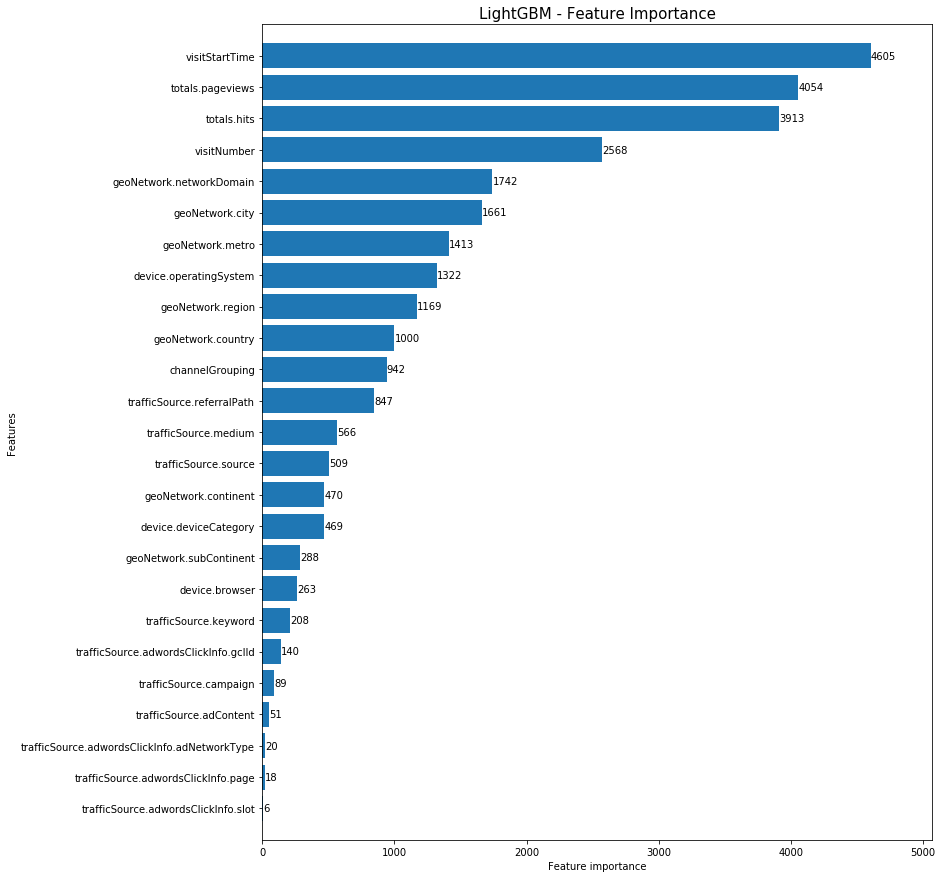

In [ ]:
fig, ax = plt.subplots(figsize=(12,15))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [ ]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

In [ ]:
sub_df

,fullVisitorId,PredictedLogRevenue
0,0000073585230191399,0.004967
1,0000268499301061358,0.007856
2,0000580593056201076,1.171397
3,0000677695778949032,0.114752
4,0000876517619312326,0.052201
...,...,...
38088,9998674836690610420,0.000000
38089,9998710573414358264,6.777259
38090,9998743345323500212,0.102186
38091,9999415736908408179,0.000000


## **Applying Logistic Regression**

In [ ]:
import numpy as np
from sklearn import linear_model


In [ ]:
dev_X['totals.pageviews'].fillna(0,inplace=True)

In [ ]:
val_X['totals.pageviews'].fillna(0,inplace=True)

In [ ]:
from sklearn import preprocessing
dev_X_scaled = preprocessing.scale(dev_X)
val_X_scaled=preprocessing.scale(val_X)

In [ ]:
def logistic_reg(train_X, train_y, val_X, val_y):
    reg = linear_model.SGDRegressor(alpha=0.0001,max_iter=1000, tol=1e-3,eta0=0.01)
    reg.fit(train_X, train_y)
    pred_val_y=reg.predict(val_X)
    return pred_val_y,reg

In [ ]:
pred_val,model = logistic_reg(dev_X_scaled, dev_y, val_X_scaled, val_y)

In [ ]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df1 = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df1["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df1["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df1 = val_pred_df1.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df1["transactionRevenue"].values), np.log1p(val_pred_df1["PredictedRevenue"].values))))

1.5883533800149874


###**Using Light GBM, we get 1.45 as rmse**

###**Using Logistic regression, we get 1.58 as rmse**

#**We will proceed forward with Light GBM**